In [271]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

pd.options.display.max_columns = 500

pd.options.display.max_rows = 5000

In [57]:
os.getcwd()
os.chdir('c:\\Users\\zach_\\Desktop\\Research\\Github\\RFE_project')
pd.set_option('display.max_columns', 500)


In [63]:
datapath = Path("data/cleaned/agg_pattern.csv")
df = pd.read_csv(datapath)

In [106]:
df.columns

Index(['Unnamed: 0', 'death', 'firms', 'industry_restrictions_1_0',
       'industry_restrictions_2_0', 'gdp', 'entry_whole', 'incumbents_whole',
       'entry_rate_whole', 'death_rate_whole'],
      dtype='object')

In [65]:
df = df.set_index(["sector_2", "year"])

In [169]:
df_test = df.unstack()

In [170]:
df_test = df_test.dropna()

In [168]:
df_test.columns(level = 1)

TypeError: 'MultiIndex' object is not callable

In [258]:
X ={}
Y = {}
yr_end = 2018
yr_begin = 1985
for yr in [yr_end, yr_begin]:
    index = [('death_rate_whole', yr), ('industry_restrictions_2_0', yr), ('gdp', yr)]
    X[yr] = df_test[index].to_numpy() 
    Y[yr] = df_test[('death_rate_whole', yr + 1)].to_numpy() 

In [259]:
import statsmodels.api as sm

x_var1 = (X[yr_end][:, 1:] - X[yr_begin][:, 1:])/ X[yr_begin][:,1:]
x_var = sm.add_constant(x_var1)
y_var = (Y[yr_end][:, 0] - Y[yr_begin][:, 0])/ Y[yr_begin][:,0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [260]:
model = sm.OLS(y_var, x_var)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     1.605
Date:                Mon, 04 Jul 2022   Prob (F-statistic):              0.245
Time:                        23:09:13   Log-Likelihood:                 13.739
No. Observations:                  14   AIC:                            -21.48
Df Residuals:                      11   BIC:                            -19.56
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2982      0.087     -3.415      0.0

c:\Users\zach_\.virtualenvs\RFE_project-5yjSZlxr\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


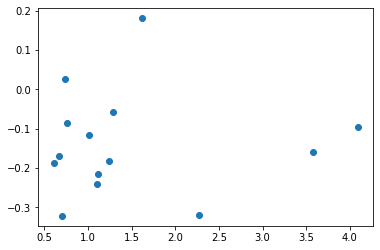

In [239]:
print(plt.scatter(x_var1, y_var))

In [261]:
datapath = Path("data/cleaned/life_path_sec_ag.csv")
df = pd.read_csv(datapath)

In [265]:
df.head()

,Unnamed: 0,year,sector,fage,firms,estabs,emp,denom,estabs_entry,estabs_entry_rate,estabs_exit,estabs_exit_rate,job_creation,job_creation_births,job_creation_continuers,job_creation_rate_births,job_creation_rate,job_destruction,job_destruction_deaths,job_destruction_continuers,job_destruction_rate_deaths,job_destruction_rate,net_job_creation,net_job_creation_rate,reallocation_rate,firmdeath_firms,firmdeath_estabs,firmdeath_emp,death,log_emp,death_rate,sector_2,sector_3,sector_4,L_1_emp,L_2_emp,L_3_emp,L_4_emp,L_5_emp,age_grp_dummy,L_0_year,L_0_industry_restrictions_1_0,L_0_industry_restrictions_2_0,L_0_gdp,L_0_entry_whole,L_0_incumbents_whole,L_0_log_restriction_1_0,L_0_log_restriction_2_0,L_0_log_gdp,L_0_entry_rate_whole,L_1_year,L_1_industry_restrictions_1_0,L_1_industry_restrictions_2_0,L_1_gdp,L_1_entry_whole,L_1_incumbents_whole,L_1_log_restriction_1_0,L_1_log_restriction_2_0,L_1_log_gdp,L_1_entry_rate_whole,L_2_year,L_2_industry_restrictions_1_0,L_2_industry_restrictions_2_0,L_2_gdp,L_2_entry_whole,L_2_incumbents_whole,L_2_log_restriction_1_0,L_2_log_restriction_2_0,L_2_log_gdp,L_2_entry_rate_whole,L_3_year,L_3_industry_restrictions_1_0,L_3_industry_restrictions_2_0,L_3_gdp,L_3_entry_whole,L_3_incumbents_whole,L_3_log_restriction_1_0,L_3_log_restriction_2_0,L_3_log_gdp,L_3_entry_rate_whole,L_4_year,L_4_industry_restrictions_1_0,L_4_industry_restrictions_2_0,L_4_gdp,L_4_entry_whole,L_4_incumbents_whole,L_4_log_restriction_1_0,L_4_log_restriction_2_0,L_4_log_gdp,L_4_entry_rate_whole,L_5_year,L_5_industry_restrictions_1_0,L_5_industry_restrictions_2_0,L_5_gdp,L_5_entry_whole,L_5_incumbents_whole,L_5_log_restriction_1_0,L_5_log_restriction_2_0,L_5_log_gdp,L_5_entry_rate_whole,log_emp_cohort,log_emp_chg,per_emp_chg,avg_log_restriction_2_0,avg_entry_rate_whole,avg_log_gdp,cohort_log_restriction_2_0,cohort_entry_rate_whole,cohort_log_gdp,inc_avg_log_restriction_2_0,inc_avg_entry_rate_whole,inc_avg_log_gdp
0,0,1978,1100,a) 0,3911.0,3919,16879.0,8440,3919,200,(X),(X),16879,16879,NaN,200,200.000,(X),(X),(X),(X),NaN,16879,200.00,(X),NaN,(X),(X),NaN,9.733826,NaN,11,110,1100,17111.0,14248.0,13552.0,11233.0,11669.0,0.0,1978.0,NaN,NaN,59.5,3911.0,19852.0,NaN,NaN,4.085976,0.197008,1977.0,NaN,NaN,51.2,NaN,NaN,NaN,NaN,3.93574,NaN,1976.0,NaN,NaN,50.1,NaN,NaN,NaN,NaN,3.914021,NaN,1975.0,NaN,NaN,51.4,NaN,NaN,NaN,NaN,3.939638,NaN,1974.0,NaN,NaN,50.1,NaN,NaN,NaN,NaN,3.914021,NaN,1973.0,NaN,NaN,52.2,NaN,NaN,NaN,NaN,3.955082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1978,1100,b) 1,3043.0,3075,16199.0,17413,15,0.402,1334,35.721,6004,101,5903.0,0.58,34.481,8346,5709,2637,32.787,47.931,-2342,-13.45,68.962,1019.0,1030,4821,1019.0,9.692705,0.334867,11,110,1100,14108.0,14115.0,11548.0,8469.0,9172.0,1.0,1978.0,NaN,NaN,59.5,3911.0,19852.0,NaN,NaN,4.085976,0.197008,1977.0,NaN,NaN,51.2,NaN,NaN,NaN,NaN,3.93574,NaN,1976.0,NaN,NaN,50.1,NaN,NaN,NaN,NaN,3.914021,NaN,1975.0,NaN,NaN,51.4,NaN,NaN,NaN,NaN,3.939638,NaN,1974.0,NaN,NaN,50.1,NaN,NaN,NaN,NaN,3.914021,NaN,1973.0,NaN,NaN,52.2,NaN,NaN,NaN,NaN,3.955082,NaN,9.554497,0.138207,0.137988,0.0,0.0,3.935740,NaN,NaN,3.935740,NaN,NaN,NaN
2,2,1978,1100,c) 2,NaN,(X),NaN,(X),(X),(X),(X),(X),(X),(X),NaN,(X),NaN,(X),(X),(X),(X),NaN,(X),NaN,(X),NaN,(X),(X),NaN,NaN,NaN,11,110,1100,12264.0,12233.0,11868.0,8738.0,7316.0,2.0,1978.0,NaN,NaN,59.5,3911.0,19852.0,NaN,NaN,4.085976,0.197008,1977.0,NaN,NaN,51.2,NaN,NaN,NaN,NaN,3.93574,NaN,1976.0,NaN,NaN,50.1,NaN,NaN,NaN,NaN,3.914021,NaN,1975.0,NaN,NaN,51.4,NaN,NaN,NaN,NaN,3.939638,NaN,1974.0,NaN,NaN,50.1,NaN,NaN,NaN,NaN,3.914021,NaN,1973.0,NaN,NaN,52.2,NaN,NaN,NaN,NaN,3.955082,NaN,9.411892,NaN,NaN,0.0,0.0,3.924880,NaN,NaN,3.914021,0.0,0.0,3.93574
3,3,1978,1100,d) 3,NaN,(X),NaN,(X),(X),(X),(X),(X),(X),(X),NaN,(X),NaN,(X),(X),(X),(X),NaN,(X),NaN,(X),NaN,(X),(X),NaN,NaN,NaN,11,110,1100,NaN,11685.0,10897.0,8979.0,7444.0,3.0,1978.0,NaN,NaN,59.5,3911.0,19852.0,NaN,NaN,4.085976,0.197008,1977.0,NaN,NaN,51.2,NaN,NaN,NaN,NaN,3.93574,NaN,1976.0,NaN,NaN,50.1,NaN,NaN,NaN,NaN,3.9140

In [272]:
df[df.fage == "b) 1"].count()

Unnamed: 0                       11802
year                             11802
sector                           11802
fage                             11802
firms                            11705
estabs                           11802
emp                              11705
denom                            11802
estabs_entry                     11802
estabs_entry_rate                11768
estabs_exit                      11802
estabs_exit_rate                 11768
job_creation                     11802
job_creation_births              11802
job_creation_continuers          11705
job_creation_rate_births         11802
job_creation_rate                11671
job_destruction                  11802
job_destruction_deaths           11802
job_destruction_continuers       11802
job_destruction_rate_deaths      11802
job_destruction_rate             11671
net_job_creation                 11802
net_job_creation_rate            11671
reallocation_rate                11802
firmdeath_firms          